# **Установка и импорт необходимых библиотек**

In [ ]:
!pip install missingno

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
import os
import tqdm
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib


In [ ]:
warnings.filterwarnings('ignore')

# **Чтение данных**

In [ ]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    Reads specified number of partitions, converts them to pd.DataFrame, and returns the concatenated result.

    Parameters:
    - path_to_dataset (str): Directory path containing the partitions.
    - start_from (int): Index of the first partition to read.
    - num_parts_to_read (int): Number of partitions to read.
    - columns (list): List of columns to read from each partition.
    - verbose (bool): If True, logs details of the reading process.

    Returns:
    - pd.DataFrame: Concatenated DataFrame of the specified partitions.
    """
    dataset_paths = sorted(
        [os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) if filename.startswith('train')]
    )

    if not dataset_paths:
        raise ValueError("No valid partitions found in the specified directory.")

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]

    if verbose:
        print(f"Reading {len(chunks)} chunks starting from partition {start_from}:")
        for chunk in chunks:
            print(f" - {chunk}")

    res = []
    for chunk_path in tqdm(chunks, desc="Reading dataset"):
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk.astype(int))  # Assuming integer conversion is required

    return pd.concat(res, ignore_index=True)


In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int = 50,
                                 save_to_path=None, verbose: bool = False) -> pd.DataFrame:
    """
    Processes the dataset and returns a DataFrame ready for modeling.

    Parameters:
    - path_to_dataset (str): Path to the dataset directory containing partitions.
    - num_parts_to_preprocess_at_once (int): Number of partitions to process in memory at once.
    - num_parts_total (int): Total number of partitions to process.
    - save_to_path (str): Directory path to save processed partitions; if None, nothing is saved.
    - verbose (bool): If True, logs processing details.

    Returns:
    - pd.DataFrame: Concatenated and processed DataFrame.
    """
    preprocessed_frames = []

    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(
            path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=verbose
        )

        # Data preprocessing placeholder (e.g., cleaning, feature engineering)
        # transactions_frame = preprocess(transactions_frame)

        # Save processed data if required
        if save_to_path:
            block_as_str = f"{step:03}"
            save_path = os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet')
            transactions_frame.to_parquet(save_path)

        preprocessed_frames.append(transactions_frame)

    return pd.concat(preprocessed_frames, ignore_index=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/train_data/'

In [ ]:
df = prepare_transactions_dataset(path, num_parts_total=12)
print("Dataset shape:", df.shape)

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset shape: (26162717, 61)


# **Разведывательный анализ данных**

напишем заранее функции которые понадобятся в работе

In [ ]:
# Check for missing values
def check_missing_values(df):
    for column in df.columns:
        print(f"In column {column}, number of missing values: {df[column].isna().sum()}")

    # Visualize missing values
    msno.matrix(df)


# Check for unique values
def check_unique_values(df):
    for column in df.columns:
        print(f"In column {column}, number of unique values: {df[column].nunique()}")


# Remove column if it exists
def remove_column(df, column_name):
    if column_name in df.columns:
        df.drop(columns=[column_name], inplace=True)
        print(f"Column {column_name} removed.")
    else:
        print(f"Column {column_name} does not exist.")
    return df

# Group and aggregate data
def group_and_round(df, group_by_column):
    df = df.groupby(group_by_column).mean()
    df = df.applymap(math.ceil)
    return df

# Handle rare categories
def handle_rare_categories(df, threshold=1.0):
    for col in df.columns:
        if col == 'id':
            continue
        else:
            group = df[col].value_counts(normalize=True) * 100
            top = group[group > threshold].to_dict()

            df[col] = df[col].apply(lambda x: x if x in top else "other")

    return df

# Convert selected columns to string type
def convert_to_string(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df

# Merge with target and drop ID column
def merge_and_cleanup(df, target_path, on_column):
    target = pd.read_csv(target_path)
    df = df.merge(target, how='left', on=on_column)
    df.drop(columns=[on_column], inplace=True, errors='ignore')
    return df

# Visualize target variable distribution
def plot_target_distribution(df, target_column):
    default_percent = (df[target_column].value_counts(normalize=True) * 100).to_dict()

    names = list(default_percent.keys())
    values = list(default_percent.values())

    plt.bar(names, values)
    plt.title('Target Variable Distribution')
    plt.xlabel('Default')
    plt.ylabel('Percentage')
    plt.show()

In [ ]:
def main_pipeline(df, target_path):
    df = group_and_round(df, 'id')
    df = handle_rare_categories(df)

    categorical_columns = [
        'pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm',
        'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit',
        'pre_loans_next_pay_summ', 'pre_loans_outstanding',
        'pre_loans_total_overdue', 'pre_loans_max_overdue_sum',
        'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
        'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'pre_util',
        'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1',
        'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6',
        'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11',
        'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15',
        'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19',
        'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23',
        'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status',
        'enc_loans_credit_type', 'enc_loans_account_cur'
    ]

    df = convert_to_string(df, categorical_columns)

    df = merge_and_cleanup(df, target_path, 'id')

    print("Final DataFrame shape:", df.shape)
    return df


In [ ]:
target_path = '/content/drive/MyDrive/Colab Notebooks/train_target.csv'

In column id, number of missing values: 0
In column rn, number of missing values: 0
In column pre_since_opened, number of missing values: 0
In column pre_since_confirmed, number of missing values: 0
In column pre_pterm, number of missing values: 0
In column pre_fterm, number of missing values: 0
In column pre_till_pclose, number of missing values: 0
In column pre_till_fclose, number of missing values: 0
In column pre_loans_credit_limit, number of missing values: 0
In column pre_loans_next_pay_summ, number of missing values: 0
In column pre_loans_outstanding, number of missing values: 0
In column pre_loans_total_overdue, number of missing values: 0
In column pre_loans_max_overdue_sum, number of missing values: 0
In column pre_loans_credit_cost_rate, number of missing values: 0
In column pre_loans5, number of missing values: 0
In column pre_loans530, number of missing values: 0
In column pre_loans3060, number of missing values: 0
In column pre_loans6090, number of missing values: 0
In co

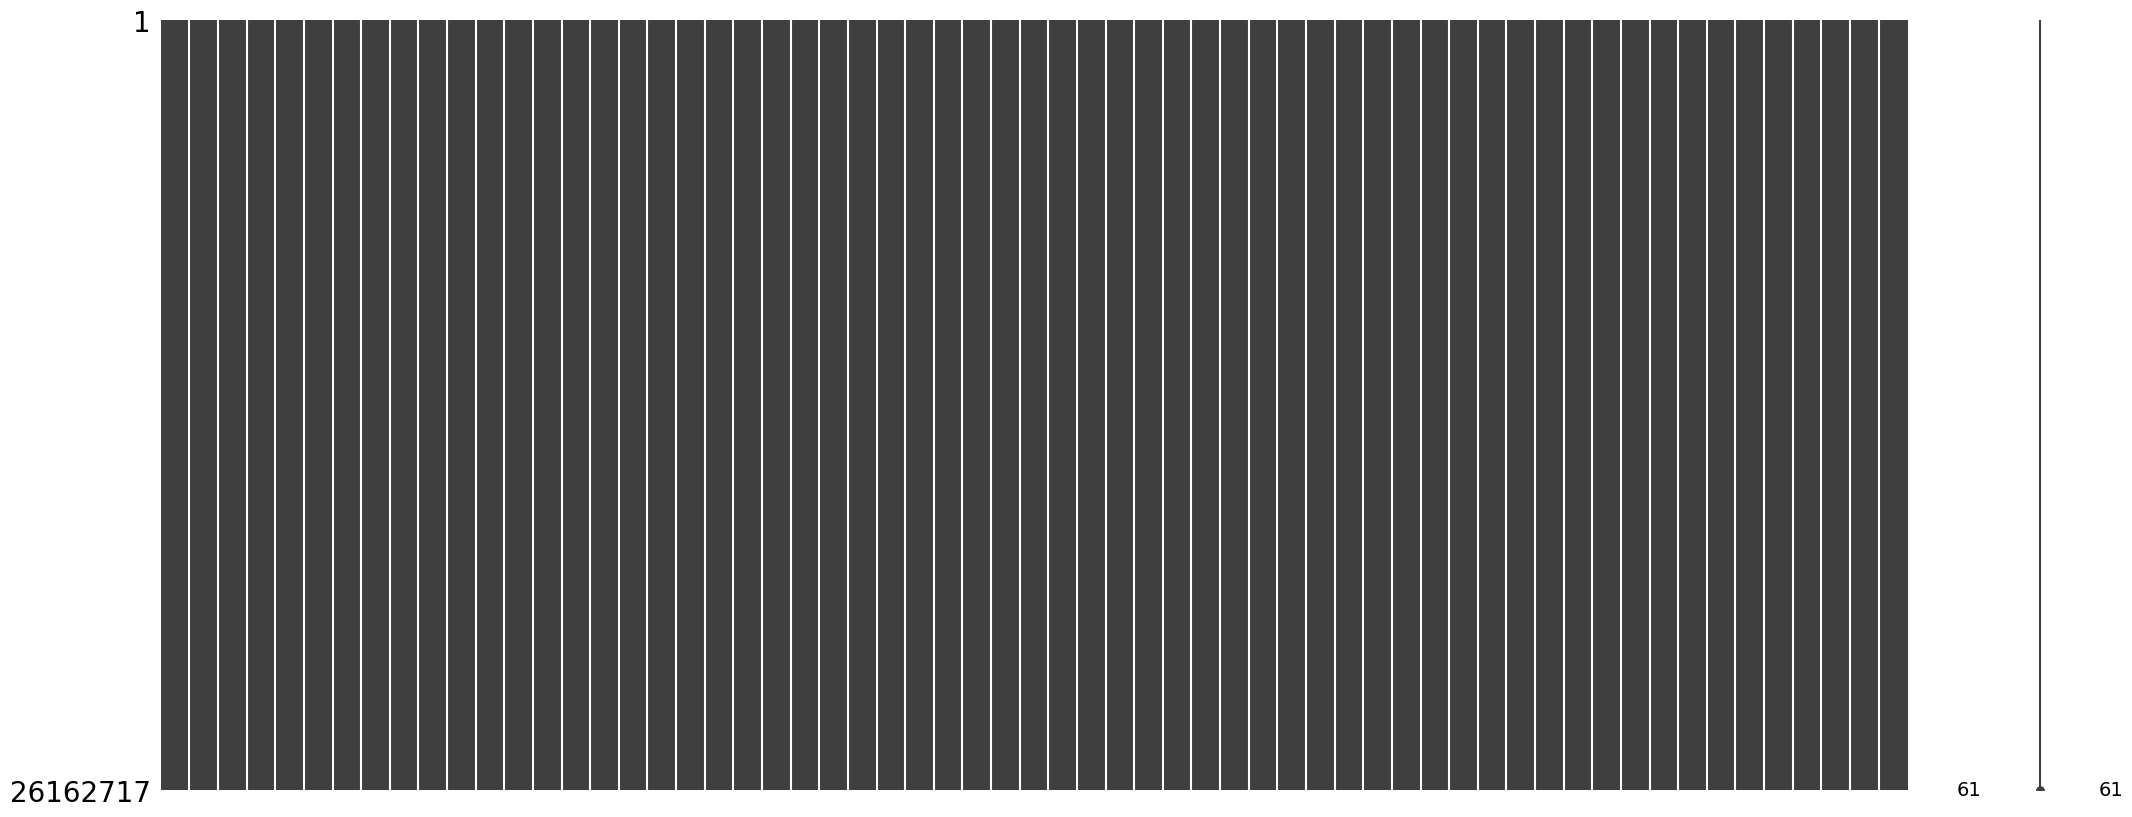

In [ ]:
check_missing_values(df)

In [ ]:
check_unique_values(df)

In column id, number of unique values: 3000000
In column rn, number of unique values: 58
In column pre_since_opened, number of unique values: 20
In column pre_since_confirmed, number of unique values: 18
In column pre_pterm, number of unique values: 18
In column pre_fterm, number of unique values: 17
In column pre_till_pclose, number of unique values: 17
In column pre_till_fclose, number of unique values: 16
In column pre_loans_credit_limit, number of unique values: 20
In column pre_loans_next_pay_summ, number of unique values: 7
In column pre_loans_outstanding, number of unique values: 5
In column pre_loans_total_overdue, number of unique values: 2
In column pre_loans_max_overdue_sum, number of unique values: 4
In column pre_loans_credit_cost_rate, number of unique values: 14
In column pre_loans5, number of unique values: 13
In column pre_loans530, number of unique values: 20
In column pre_loans3060, number of unique values: 10
In column pre_loans6090, number of unique values: 5
In co

In [ ]:
remove_column(df, 'rn')

Column rn removed.


,id,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,18,9,2,3,16,10,11,3,3,...,3,3,3,4,1,3,4,1,0,0
1,0,18,9,14,14,12,12,0,3,3,...,0,0,0,4,1,3,4,1,0,0
2,0,18,9,4,8,1,11,11,0,5,...,0,0,0,4,1,2,3,1,1,1
3,0,4,1,9,12,16,7,12,2,3,...,3,3,3,4,1,3,1,1,0,0
4,0,5,12,15,2,11,12,10,2,3,...,3,3,3,4,1,3,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162712,2499999,3,9,4,3,1,12,6,2,3,...,3,3,3,4,1,3,4,1,1,0
26162713,2499999,3,9,1,15,12,6,9,3,3,...,3,3,3,4,1,3,4,1,0,0
26162714,2499999,2,9,4,8,1,11,7,3,5,...,3,3,3,4,1,2,3,1,1,1
26162715,2499999,2,9,4,9,1,15,16,2,3,...,3,3,3,4,1,3,4,1,1,0


In [ ]:
df = main_pipeline(df, target_path)

Final DataFrame shape: (3000000, 60)


In [ ]:
df.head()

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,9,8,8,8,12,11,10,4,3,0,...,3,3,4,1,3,4,1,1,1,0
1,12,8,7,8,11,7,9,3,3,0,...,3,3,4,1,3,4,1,1,1,0
2,9,11,7,6,5,9,other,2,3,0,...,3,3,4,1,3,4,1,1,1,0
3,7,8,8,8,6,9,10,3,4,0,...,2,2,3,1,3,4,1,1,1,0
4,12,9,4,8,1,11,12,1,3,0,...,3,3,4,1,2,3,1,1,1,0


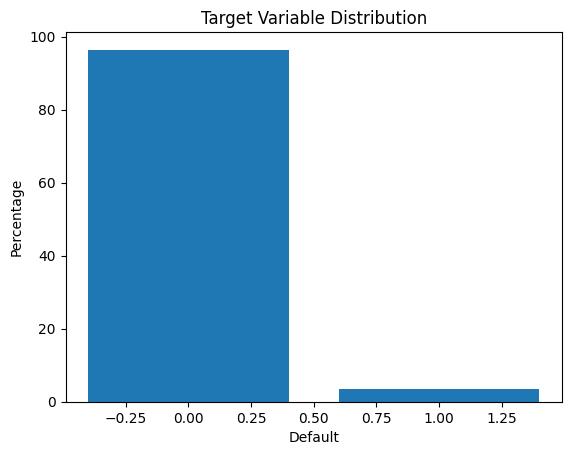

In [ ]:
plot_target_distribution(df, 'flag')

# **Feature selection**

Для начала обучим бейслайн модель и получим стартовую метрику качества, затем
проведем отбор признаков.
Будем использовать ансамблевые модели catboost и lgbm, так как категориальных признаков достаточно много.

In [ ]:
# Функция для разделения данных на обучающую, валидационную и тестовую выборки
def split_data(X, y, train_size=0.7):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=123, stratify=y)
    Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, train_size=train_size, random_state=123, stratify=ytrain)
    return Xtrain, Xval, Xtest, ytrain, yval, ytest

In [ ]:
# Функция для оценки качества модели
def evaluate_model(model, Xval, yval):
    predictions = model.predict_proba(Xval)[:, 1]
    auc = roc_auc_score(yval, predictions)
    print(f'AUC: {auc}')
    return auc

In [ ]:
# ROC-кривая
from sklearn.metrics import roc_curve
def plot_roc_curve(model, Xval, yval):
    predictions = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, predictions)

# AUC-ROC
    roc_auc = roc_auc_score(yval, predictions)

# Построение графика
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC-кривая (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Случайная модель")
    plt.title("ROC-кривая")
    plt.xlabel("Доля ложноположительных (FPR)")
    plt.ylabel("Доля истинноположительных (TPR)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
#разделим данные
X = df.drop(columns=['flag'], axis=0)
y = df['flag']

In [ ]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(X, y, train_size=0.7)

In [ ]:
#посмотрим на распределение целевой переменной ytrain
print("Процент совершения дефолта -", ytrain.value_counts()[1]/len(ytrain)*100)
print("Процент НЕ совершения дефолта -", ytrain.value_counts()[0]/len(ytrain)*100)

Процент совершения дефолта - 3.548027210884354
Процент НЕ совершения дефолта - 96.45197278911564


In [ ]:
#посмотрим на распределение целевой переменной ytest
print("Процент совершения дефолта -", ytest.value_counts()[1]/len(ytest)*100)
print("Процент НЕ совершения дефолта -", ytest.value_counts()[0]/len(ytest)*100)

Процент совершения дефолта - 3.548111111111111
Процент НЕ совершения дефолта - 96.45188888888889


In [ ]:
#посмотрим на распределение целевой переменной yval
print("Процент совершения дефолта -", yval.value_counts()[1]/len(yval)*100)
print("Процент НЕ совершения дефолта -", yval.value_counts()[0]/len(yval)*100)

Процент совершения дефолта - 3.548095238095238
Процент НЕ совершения дефолта - 96.45190476190476


In [ ]:
#обозначим категориальные признаки для модели
categories = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur']

In [ ]:
categorical_features = [X.columns.get_loc(col) for col in categories]

In [ ]:
#объявим обучающее и валидационное множество
train_pool = Pool(Xtrain, ytrain, cat_features=categorical_features)
eval = Pool(Xval, yval, cat_features=categorical_features)

In [ ]:
model = CatBoostClassifier(iterations=300, learning_rate=0.3, random_seed=42, use_best_model=True, class_weights={0: 1, 1: 10})
model.fit(train_pool, eval_set=eval)

0:	learn: 0.6251005	test: 0.6249364	best: 0.6249364 (0)	total: 4.23s	remaining: 21m 6s
1:	learn: 0.5927090	test: 0.5923945	best: 0.5923945 (1)	total: 8.05s	remaining: 19m 58s
2:	learn: 0.5758251	test: 0.5754812	best: 0.5754812 (2)	total: 10.1s	remaining: 16m 36s
3:	learn: 0.5665279	test: 0.5661681	best: 0.5661681 (3)	total: 12.1s	remaining: 14m 54s
4:	learn: 0.5587928	test: 0.5583210	best: 0.5583210 (4)	total: 15.6s	remaining: 15m 21s
5:	learn: 0.5536450	test: 0.5530987	best: 0.5530987 (5)	total: 19s	remaining: 15m 32s
6:	learn: 0.5506355	test: 0.5500662	best: 0.5500662 (6)	total: 21.8s	remaining: 15m 14s
7:	learn: 0.5487339	test: 0.5481783	best: 0.5481783 (7)	total: 25.6s	remaining: 15m 34s
8:	learn: 0.5471919	test: 0.5467269	best: 0.5467269 (8)	total: 29.4s	remaining: 15m 51s
9:	learn: 0.5460145	test: 0.5455661	best: 0.5455661 (9)	total: 32.9s	remaining: 15m 53s
10:	learn: 0.5449456	test: 0.5446054	best: 0.5446054 (10)	total: 36.3s	remaining: 15m 53s
11:	learn: 0.5443047	test: 0.5439

In [ ]:
# Оценка модели
evaluate_model(model, Xval, yval)

AUC: 0.6903123049380334


0.6903123049380334

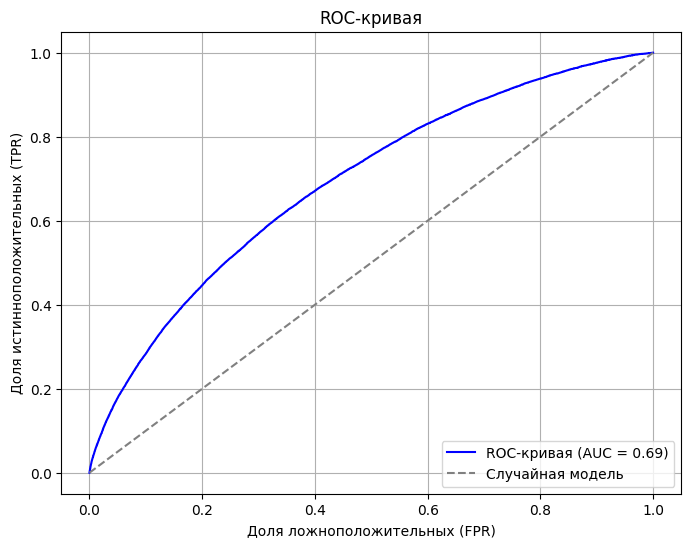

In [ ]:
plot_roc_curve(model, Xval, yval)

In [ ]:
print(model.best_iteration_)

128


In [ ]:
#посмотрим на вклад фичей в обучение модели
importance = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), X.columns), reverse=True)

In [ ]:
importance

[(13.4933, 'enc_paym_3'),
 (12.3942, 'pre_util'),
 (7.4587, 'enc_loans_credit_type'),
 (6.7158, 'enc_paym_0'),
 (5.4788, 'pre_maxover2limit'),
 (4.3858, 'enc_paym_1'),
 (3.5274, 'enc_loans_account_holder_type'),
 (3.2949, 'is_zero_util'),
 (2.3943, 'pre_loans_outstanding'),
 (2.1591, 'pre_over2limit'),
 (2.0581, 'enc_loans_credit_status'),
 (2.0378, 'pclose_flag'),
 (2.0265, 'enc_paym_6'),
 (1.9799, 'enc_paym_17'),
 (1.7757, 'pre_loans_credit_cost_rate'),
 (1.77, 'pre_till_pclose'),
 (1.6762, 'enc_paym_14'),
 (1.5999, 'is_zero_loans530'),
 (1.3704, 'pre_loans_credit_limit'),
 (1.2499, 'pre_since_opened'),
 (1.2432, 'enc_paym_16'),
 (1.2191, 'pre_fterm'),
 (1.2092, 'pre_loans_next_pay_summ'),
 (1.2029, 'pre_pterm'),
 (1.1581, 'enc_paym_7'),
 (1.1129, 'enc_paym_2'),
 (1.0573, 'pre_since_confirmed'),
 (0.9677, 'enc_paym_19'),
 (0.8587, 'pre_till_fclose'),
 (0.821, 'enc_paym_8'),
 (0.8057, 'enc_paym_4'),
 (0.7411, 'enc_paym_5'),
 (0.7303, 'fclose_flag'),
 (0.6678, 'enc_paym_23'),
 (0.6598,

In [ ]:
#теперь с помощью модели попробуем отобрать 20 наиболее важных фичей
model = CatBoostClassifier(iterations=150, learning_rate=0.3, random_seed=42, class_weights={0: 1, 1: 10})
model.select_features(train_pool, train_final_model=False, features_for_select=Xtrain.columns, num_features_to_select=20, verbose=True)


Step #1 out of 1
0:	learn: 0.6320655	total: 981ms	remaining: 2m 26s
1:	learn: 0.6033614	total: 2.04s	remaining: 2m 30s
2:	learn: 0.5823115	total: 2.92s	remaining: 2m 23s
3:	learn: 0.5723632	total: 3.77s	remaining: 2m 17s
4:	learn: 0.5662294	total: 4.64s	remaining: 2m 14s
5:	learn: 0.5613760	total: 5.48s	remaining: 2m 11s
6:	learn: 0.5580544	total: 6.34s	remaining: 2m 9s
7:	learn: 0.5546322	total: 7.31s	remaining: 2m 9s
8:	learn: 0.5523935	total: 8.21s	remaining: 2m 8s
9:	learn: 0.5503120	total: 9.09s	remaining: 2m 7s
10:	learn: 0.5482938	total: 9.92s	remaining: 2m 5s
11:	learn: 0.5467497	total: 10.7s	remaining: 2m 3s
12:	learn: 0.5460033	total: 11.7s	remaining: 2m 3s
13:	learn: 0.5452858	total: 12.6s	remaining: 2m 2s
14:	learn: 0.5446431	total: 13.4s	remaining: 2m 1s
15:	learn: 0.5440697	total: 14.4s	remaining: 2m
16:	learn: 0.5435904	total: 15.4s	remaining: 2m
17:	learn: 0.5431445	total: 16.3s	remaining: 1m 59s
18:	learn: 0.5427239	total: 17.2s	remaining: 1m 58s
19:	learn: 0.5420715	t

{'selected_features': [5,
  7,
  8,
  11,
  18,
  22,
  23,
  24,
  25,
  28,
  29,
  30,
  31,
  34,
  35,
  42,
  46,
  53,
  54,
  55],
 'eliminated_features_names': ['enc_paym_10',
  'enc_paym_12',
  'enc_paym_16',
  'enc_paym_17',
  'enc_paym_22',
  'pre_loans_total_overdue',
  'is_zero_over2limit',
  'pre_loans6090',
  'is_zero_loans6090',
  'enc_paym_19',
  'is_zero_loans5',
  'enc_paym_5',
  'enc_paym_21',
  'enc_paym_15',
  'is_zero_maxover2limit',
  'pre_loans90',
  'enc_paym_13',
  'is_zero_loans90',
  'enc_paym_20',
  'fclose_flag',
  'enc_loans_account_cur',
  'pre_loans_max_overdue_sum',
  'enc_paym_11',
  'pre_loans5',
  'pre_loans530',
  'enc_paym_23',
  'enc_paym_24',
  'enc_paym_9',
  'pre_pterm',
  'pre_loans3060',
  'enc_paym_4',
  'pre_till_pclose',
  'pre_fterm',
  'pre_since_opened',
  'pclose_flag',
  'is_zero_loans3060',
  'enc_paym_8',
  'pre_loans_credit_limit',
  'pre_since_confirmed'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0,
   

**Проведем эксперимент и обучим модель на отобранных признаках**

In [ ]:
df1=df.copy()

In [ ]:
columns=['pre_till_fclose',
  'pre_loans_next_pay_summ',
  'pre_loans_outstanding',
  'pre_loans_credit_cost_rate',
  'is_zero_loans530',
  'pre_util',
  'pre_over2limit',
  'pre_maxover2limit',
  'is_zero_util',
  'enc_paym_0',
  'enc_paym_1',
  'enc_paym_2',
  'enc_paym_3',
  'enc_paym_6',
  'enc_paym_7',
  'enc_paym_14',
  'enc_paym_18',
  'enc_loans_account_holder_type',
  'enc_loans_credit_status',
  'enc_loans_credit_type', 'flag']

In [ ]:
for column in df1.columns:
    if column not in columns:
        df1 = remove_column(df1, column)

Column pre_since_opened removed.
Column pre_since_confirmed removed.
Column pre_pterm removed.
Column pre_fterm removed.
Column pre_till_pclose removed.
Column pre_loans_credit_limit removed.
Column pre_loans_total_overdue removed.
Column pre_loans_max_overdue_sum removed.
Column pre_loans5 removed.
Column pre_loans530 removed.
Column pre_loans3060 removed.
Column pre_loans6090 removed.
Column pre_loans90 removed.
Column is_zero_loans5 removed.
Column is_zero_loans3060 removed.
Column is_zero_loans6090 removed.
Column is_zero_loans90 removed.
Column is_zero_over2limit removed.
Column is_zero_maxover2limit removed.
Column enc_paym_4 removed.
Column enc_paym_5 removed.
Column enc_paym_8 removed.
Column enc_paym_9 removed.
Column enc_paym_10 removed.
Column enc_paym_11 removed.
Column enc_paym_12 removed.
Column enc_paym_13 removed.
Column enc_paym_15 removed.
Column enc_paym_16 removed.
Column enc_paym_17 removed.
Column enc_paym_19 removed.
Column enc_paym_20 removed.
Column enc_paym_21

In [ ]:
X = df1.drop(columns=['flag'], axis=0)
y = df1['flag']

In [ ]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(X, y, train_size=0.7)

In [ ]:
df1.columns

Index(['pre_till_fclose', 'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_credit_cost_rate', 'is_zero_loans530', 'pre_util',
       'pre_over2limit', 'pre_maxover2limit', 'is_zero_util', 'enc_paym_0',
       'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_14', 'enc_paym_18', 'enc_loans_account_holder_type',
       'enc_loans_credit_status', 'enc_loans_credit_type', 'flag'],
      dtype='object')

In [ ]:
categories = ['pre_till_fclose', 'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_credit_cost_rate', 'is_zero_loans530', 'pre_util',
       'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0',
       'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_14', 'enc_paym_18', 'enc_loans_account_holder_type',
       'enc_loans_credit_status', 'enc_loans_credit_type']

In [ ]:
categorical_features = [X.columns.get_loc(col) for col in categories]

In [ ]:
train_pool = Pool(Xtrain, ytrain, cat_features=categorical_features)
eval = Pool(Xval, yval, cat_features=categorical_features)

In [ ]:
model = CatBoostClassifier(iterations=150, learning_rate=0.3, random_seed=42, use_best_model=True, class_weights={0: 1, 1: 10})
model.fit(train_pool, eval_set=eval)

0:	learn: 0.6323722	test: 0.6323552	best: 0.6323552 (0)	total: 517ms	remaining: 1m 17s
1:	learn: 0.6039659	test: 0.6039298	best: 0.6039298 (1)	total: 963ms	remaining: 1m 11s
2:	learn: 0.5823094	test: 0.5821092	best: 0.5821092 (2)	total: 1.49s	remaining: 1m 13s
3:	learn: 0.5721635	test: 0.5718444	best: 0.5718444 (3)	total: 1.99s	remaining: 1m 12s
4:	learn: 0.5673603	test: 0.5669561	best: 0.5669561 (4)	total: 2.61s	remaining: 1m 15s
5:	learn: 0.5624089	test: 0.5620336	best: 0.5620336 (5)	total: 3.13s	remaining: 1m 15s
6:	learn: 0.5589088	test: 0.5584325	best: 0.5584325 (6)	total: 3.59s	remaining: 1m 13s
7:	learn: 0.5567898	test: 0.5562752	best: 0.5562752 (7)	total: 4.06s	remaining: 1m 12s
8:	learn: 0.5541677	test: 0.5535932	best: 0.5535932 (8)	total: 4.53s	remaining: 1m 10s
9:	learn: 0.5524016	test: 0.5518602	best: 0.5518602 (9)	total: 4.98s	remaining: 1m 9s
10:	learn: 0.5508489	test: 0.5504326	best: 0.5504326 (10)	total: 5.44s	remaining: 1m 8s
11:	learn: 0.5498962	test: 0.5494715	best: 

In [ ]:
# Оценка модели
evaluate_model(model, Xval, yval)

AUC: 0.6821807588919934


0.6821807588919934

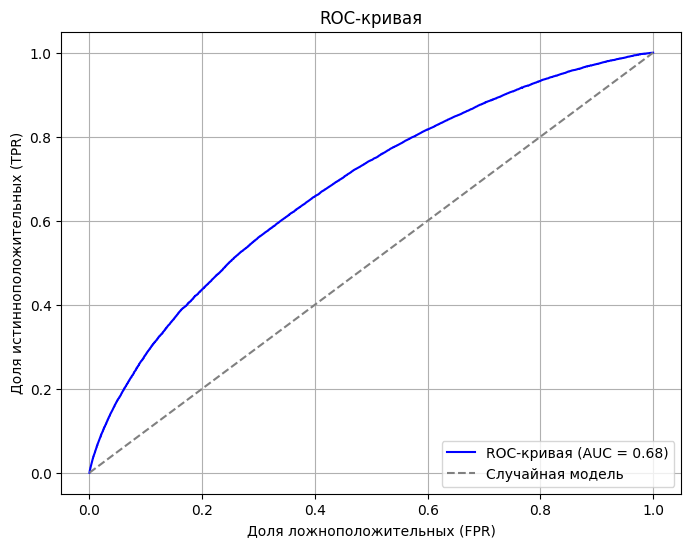

In [ ]:
plot_roc_curve(model, Xval, yval)

**Видим что качество модели ухудшилось**

**Теперь проведем такой же эксперимент с lightbm**

In [ ]:
df = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=1, num_parts_total=12)

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df = remove_column(df, 'rn')

Column rn removed.


In [ ]:
def main_pipeline_for_lgbm(df, target_path):
    df = group_and_round(df, 'id')
    df = merge_and_cleanup(df, target_path, 'id')

    print("Final DataFrame shape:", df.shape)
    return df

In [ ]:
df = main_pipeline_for_lgbm(df, target_path)

Final DataFrame shape: (3000000, 60)


In [ ]:
X = df.drop(columns=['flag'], axis=0)
y = df['flag']

In [ ]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(X, y, train_size=0.7)

In [ ]:
categories = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm',
       'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit',
       'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_total_overdue', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
       'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4',
       'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
       'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13',
       'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
       'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
       'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur']

In [ ]:
categorical_features = [X.columns.get_loc(col) for col in categories]

In [ ]:
lgbm = LGBMClassifier(is_unbalance=True, objective='binary')

In [ ]:
lgbm.fit(Xtrain, ytrain, categorical_feature=categorical_features)

[LightGBM] [Info] Number of positive: 52156, number of negative: 1417844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 1470000, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302653
[LightGBM] [Info] Start training from score -3.302653


LGBMClassifier(is_unbalance=True, objective='binary')

In [ ]:
# Оценка модели
evaluate_model(lgbm, Xval, yval)

AUC: 0.6872130293880993


0.6872130293880993

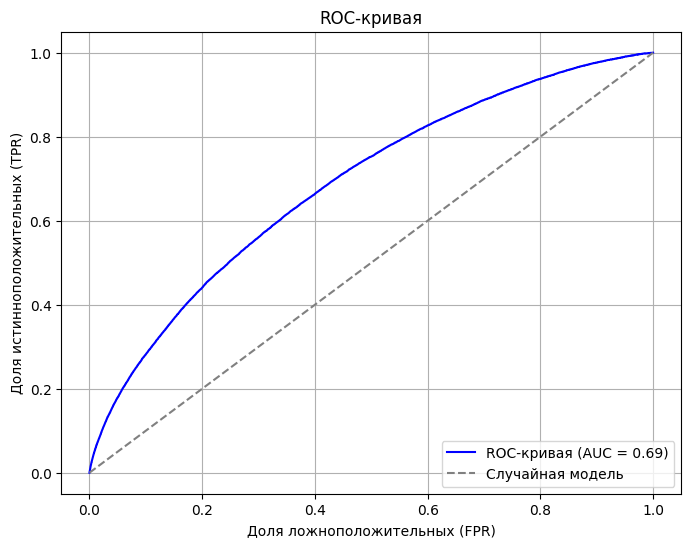

In [ ]:
plot_roc_curve(lgbm, Xval, yval)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

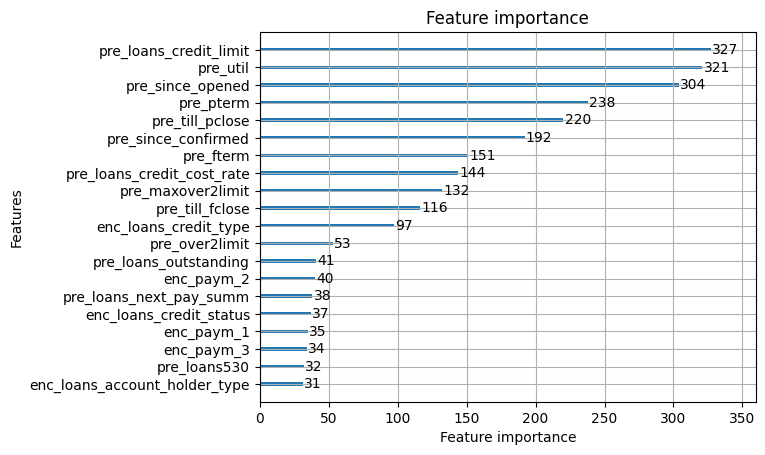

In [ ]:
lgb.plot_importance(lgbm, max_num_features=20)

In [ ]:
importance = sorted(zip(map(lambda x: x, lgbm.feature_importances_), X.columns), reverse=True)
importance

[(327, 'pre_loans_credit_limit'),
 (321, 'pre_util'),
 (304, 'pre_since_opened'),
 (238, 'pre_pterm'),
 (220, 'pre_till_pclose'),
 (192, 'pre_since_confirmed'),
 (151, 'pre_fterm'),
 (144, 'pre_loans_credit_cost_rate'),
 (132, 'pre_maxover2limit'),
 (116, 'pre_till_fclose'),
 (97, 'enc_loans_credit_type'),
 (53, 'pre_over2limit'),
 (41, 'pre_loans_outstanding'),
 (40, 'enc_paym_2'),
 (38, 'pre_loans_next_pay_summ'),
 (37, 'enc_loans_credit_status'),
 (35, 'enc_paym_1'),
 (34, 'enc_paym_3'),
 (32, 'pre_loans530'),
 (31, 'enc_loans_account_holder_type'),
 (25, 'pre_loans_max_overdue_sum'),
 (23, 'enc_paym_0'),
 (22, 'pre_loans5'),
 (19, 'pre_loans3060'),
 (18, 'pclose_flag'),
 (18, 'enc_paym_7'),
 (18, 'enc_loans_account_cur'),
 (17, 'is_zero_loans530'),
 (17, 'enc_paym_5'),
 (14, 'enc_paym_8'),
 (13, 'is_zero_loans90'),
 (13, 'is_zero_loans3060'),
 (13, 'enc_paym_20'),
 (13, 'enc_paym_10'),
 (12, 'enc_paym_6'),
 (12, 'enc_paym_4'),
 (12, 'enc_paym_23'),
 (11, 'pre_loans90'),
 (11, 'enc_

# **Проведем дополнительный анализ данных**

Строим графики распределения некоторых переменных, в связи со значением цедевой переменной
Для удобства создадим переменные количество есть дефолт, и дефолта нет.

In [ ]:
df = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=1, num_parts_total=12)

Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df = remove_column(df, 'rn')

Column rn removed.


In [ ]:
target = pd.read_csv(target_path)

In [ ]:
df = df.merge(target, how='left', on='id')

In [ ]:
df.shape

(26162717, 61)

**Основываясь на результатах вклада отдельных признаков в обучение моделей, а также на собственной интуиции понимания природы данных отберем признаки с которыми продолжим дальнейшую работу**

In [ ]:
columns = ['id', 'pre_pterm', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'enc_loans_account_holder_type',
       'enc_loans_credit_status', 'enc_loans_account_cur',
       'enc_loans_credit_type', 'is_zero_loans5', 'is_zero_loans530',
       'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90',
       'pre_since_opened', 'pre_loans_credit_limit', 'pre_util', 'pclose_flag',
       'fclose_flag', 'flag']

In [ ]:
for column in df.columns:
    if column not in columns:
        df = remove_column(df, column)

Column pre_since_confirmed removed.
Column pre_fterm removed.
Column pre_till_pclose removed.
Column pre_till_fclose removed.
Column pre_loans_total_overdue removed.
Column pre_loans5 removed.
Column pre_loans530 removed.
Column pre_loans3060 removed.
Column pre_loans6090 removed.
Column pre_loans90 removed.
Column pre_over2limit removed.
Column pre_maxover2limit removed.
Column is_zero_util removed.
Column is_zero_over2limit removed.
Column is_zero_maxover2limit removed.
Column enc_paym_0 removed.
Column enc_paym_1 removed.
Column enc_paym_2 removed.
Column enc_paym_3 removed.
Column enc_paym_4 removed.
Column enc_paym_5 removed.
Column enc_paym_6 removed.
Column enc_paym_7 removed.
Column enc_paym_8 removed.
Column enc_paym_9 removed.
Column enc_paym_10 removed.
Column enc_paym_11 removed.
Column enc_paym_12 removed.
Column enc_paym_13 removed.
Column enc_paym_14 removed.
Column enc_paym_15 removed.
Column enc_paym_16 removed.
Column enc_paym_17 removed.
Column enc_paym_18 removed.
C

In [ ]:
flag1 = len(df[df["flag"]==1])
flag0 = len(df[df["flag"]==0])

In [ ]:
# Функция для анализа распределения переменных
def analyze_feature_distribution(df, feature):
    count1 = df[df["flag"] == 1].groupby([feature], as_index=False).agg({"flag": "count"}).sort_values(["flag"], ascending=False)
    count1['flag_1'] = count1["flag"].apply(lambda x: x / flag1 * 100)
    count0 = df[df["flag"] == 0].groupby([feature], as_index=False).agg({"flag": "count"}).sort_values(["flag"], ascending=False)
    count0['flag_0'] = count0["flag"].apply(lambda x: x / flag0 * 100)
    count1 = count1.merge(count0, how="inner", on=feature)
    return count1

In [ ]:
# Анализ распределения переменных
columns_to_analyze = ['pre_pterm', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate',
                      'enc_loans_account_holder_type', 'enc_loans_credit_status', 'enc_loans_account_cur', 'enc_loans_credit_type',
                      'pre_since_opened', 'pre_loans_credit_limit', 'pre_util']
for column in columns_to_analyze:
    print(f"Распределение для {column}:")
    print(analyze_feature_distribution(df, column))

Распределение для pre_pterm:
    pre_pterm  flag_x     flag_1   flag_y     flag_0
0           4  177005  20.118571  4279180  16.925189
1          14   82012   9.321569  2254492   8.917060
2           3   50206   5.706466   872996   3.452910
3          16   48253   5.484486  1412730   5.587688
4          11   46668   5.304333  1383791   5.473227
5           2   46492   5.284329  1485737   5.876448
6           9   45583   5.181011  1382617   5.468584
7          17   44905   5.103949  1475513   5.836010
8           1   44849   5.097584  1438358   5.689053
9           7   43042   4.892198  1348822   5.334916
10          0   42384   4.817409  1270002   5.023164
11          8   41254   4.688972  1266587   5.009657
12         15   41096   4.671014  1253457   4.957725
13         13   39800   4.523709  1270340   5.024501
14         12   38759   4.405388  1166875   4.615272
15          6   35973   4.088728  1364032   5.395076
16         10   11420   1.298009   356519   1.410119
17          5    

In [ ]:
delete_column=['pre_loans_next_pay_summ',
 'enc_loans_account_holder_type',
 'enc_loans_account_cur']

In [ ]:
for column in delete_column:
    df = remove_column(df, column)

Column pre_loans_next_pay_summ removed.
Column enc_loans_account_holder_type removed.
Column enc_loans_account_cur removed.


In [ ]:
handle_rare_categories(df, threshold=1.0)

,id,pre_since_opened,pre_pterm,pre_loans_credit_limit,pre_loans_outstanding,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,enc_loans_credit_status,enc_loans_credit_type,pclose_flag,fclose_flag,flag
0,0,18,2,11,3,2,11,1,1,1,1,1,16,3,4,0,0,0
1,0,18,14,0,3,2,11,1,1,1,1,1,16,3,4,0,0,0
2,0,18,4,11,5,2,8,1,1,1,1,1,15,2,3,1,1,0
3,0,4,9,12,3,2,4,0,1,1,1,1,16,3,1,0,0,0
4,0,5,15,10,3,2,4,1,1,1,1,1,16,3,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26162712,2499999,3,4,6,3,2,7,1,1,1,1,1,16,3,4,1,0,0
26162713,2499999,3,1,9,3,2,11,1,1,1,1,1,16,3,4,0,0,0
26162714,2499999,2,4,7,5,1,5,1,0,1,1,1,1,2,3,1,1,0
26162715,2499999,2,4,16,3,1,2,1,0,1,1,1,16,3,4,1,0,0


# **Добавим некоторые признаки-маркеры дефолта (признаки в которых процент дефолта больше чем не дефолта)**

In [ ]:
def mark(x):
    if x  == 4 or x==3:
        return True
    else:
        return False

# редкие категории группируем в other
df.loc[:, 'mark_pterm'] = df['pre_pterm'].apply(mark)

In [ ]:
def mark(x):
        if x  == 1:
            return True
        else:
            return False

# редкие категории группируем в other
df.loc[:, 'mark_maxoverdue'] = df['pre_loans_max_overdue_sum'].apply(mark)

In [ ]:
def mark(x):
        if x  == 6:
            return True
        else:
            return False

# редкие категории группируем в other
df.loc[:, 'mark_credit_cost'] = df['pre_loans_credit_cost_rate'].apply(mark)

In [ ]:
def mark(x):
        if x  == 5:
            return True
        else:
            return False

# редкие категории группируем в other
df.loc[:, 'mark_credit_type'] = df['enc_loans_credit_type'].apply(mark)

In [ ]:
def mark(x):
        if x  == 3 or x==6:
            return True
        else:
            return False

# редкие категории группируем в other
df.loc[:, 'mark_util'] = df['pre_util'].apply(mark)

# **Проведем группировку по 'id' и обучим модель**

In [ ]:
cols = ['pre_pterm', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'enc_loans_credit_status',
       'enc_loans_credit_type','pre_since_opened', 'pre_loans_credit_limit', 'pre_util']
for col in cols:
    df[col]= df[col].astype(str)

Категориальные признаки будем кодировать с помощбю OHE, т.к. это позволит корректно сгруппировать наши данные в дальнейшем.

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

In [ ]:
one_hot_encoded = ohe.fit_transform(df[cols])

In [ ]:
df[ohe.get_feature_names_out()] = one_hot_encoded

In [ ]:
df = df.drop(columns=['pre_pterm', 'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'enc_loans_credit_status',
       'enc_loans_credit_type','pre_since_opened', 'pre_loans_credit_limit', 'pre_util'], axis=0)

In [ ]:
df.head()

,id,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pclose_flag,fclose_flag,flag,mark_pterm,...,pre_util_11,pre_util_15,pre_util_16,pre_util_18,pre_util_3,pre_util_4,pre_util_6,pre_util_7,pre_util_9,pre_util_other
0,0,1,1,1,1,1,0,0,0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,1,1,1,1,0,0,0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,1,1,1,0,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,1,1,1,0,0,0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,1,1,1,0,0,0,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#ПРОВЕДЕМ ГРУППИРОВКУ ДАННЫХ ПО КОЛОНКЕ id, в качестве аггрегационной функции используем среднее
df = df.groupby('id').mean()

In [ ]:
df.head()

,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pclose_flag,fclose_flag,flag,mark_pterm,mark_maxoverdue,...,pre_util_11,pre_util_15,pre_util_16,pre_util_18,pre_util_3,pre_util_4,pre_util_6,pre_util_7,pre_util_9,pre_util_other
id,,,,,,,,,,,,,,,,,,,,,
0,0.900000,1.000000,1.000000,1.000000,1.000000,0.100000,0.200000,0.0,0.100000,0.000000,...,0.0,0.2,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.100000,0.000000
1,0.857143,0.714286,0.857143,0.857143,0.785714,0.071429,0.142857,0.0,0.071429,0.142857,...,0.0,0.0,0.714286,0.000000,0.071429,0.000000,0.071429,0.0,0.000000,0.071429
2,1.000000,0.666667,0.666667,0.666667,1.000000,0.666667,0.666667,0.0,0.666667,0.333333,...,0.0,0.0,0.333333,0.000000,0.333333,0.000000,0.333333,0.0,0.000000,0.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,0.333333,0.400000,0.0,0.333333,0.000000,...,0.0,0.0,0.533333,0.066667,0.066667,0.066667,0.066667,0.0,0.066667,0.133333
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,...,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [ ]:
def flag(x):
        if x > 0.0:
            return 1.0
        else:
            return 0.0


df.loc[:, 'flag'] = df['flag'].apply(flag)

In [ ]:
df['flag'].unique()

array([0., 1.])

In [ ]:
df.shape

(3000000, 118)

## **Train test split**

In [ ]:
X = df.drop(columns=['flag'], axis=0)
y = df['flag']

In [ ]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = split_data(X, y, train_size=0.7)

#**Catboost classifier**

In [ ]:
model = CatBoostClassifier(iterations=300, learning_rate=0.3, random_seed=42, use_best_model=True, class_weights={0: 1, 1: 10})
model.fit(Xtrain, ytrain, verbose=False, eval_set=(Xval, yval))


In [ ]:
evaluate_model(model, Xval, yval)

AUC: 0.748917899930235


0.748917899930235

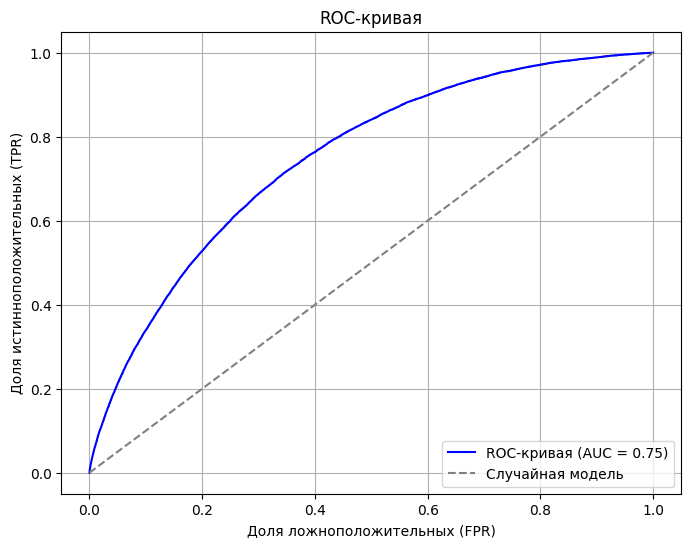

In [ ]:
plot_roc_curve(model, Xval, yval)

In [ ]:
model.best_iteration_

184

**Подбор наиболее важных гиперпараметров**

In [ ]:
model = CatBoostClassifier(random_seed=42, class_weights={0: 1, 1: 10})
model_params = {'learning_rate':  [0.1, 0.2, 0.3],
                'iterations': [200, 300, 400, 500]}

In [ ]:
scores=[]

clf = GridSearchCV(model, model_params, cv=4, scoring='roc_auc', n_jobs=-1)
clf.fit(Xtrain, ytrain)
scores.append({
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })

0:	learn: 0.6622342	total: 241ms	remaining: 2m
1:	learn: 0.6378254	total: 480ms	remaining: 1m 59s
2:	learn: 0.6177616	total: 704ms	remaining: 1m 56s
3:	learn: 0.6013634	total: 933ms	remaining: 1m 55s
4:	learn: 0.5882811	total: 1.17s	remaining: 1m 55s
5:	learn: 0.5772217	total: 1.41s	remaining: 1m 55s
6:	learn: 0.5684021	total: 1.64s	remaining: 1m 55s
7:	learn: 0.5612761	total: 1.9s	remaining: 1m 56s
8:	learn: 0.5556861	total: 2.13s	remaining: 1m 55s
9:	learn: 0.5511411	total: 2.35s	remaining: 1m 55s
10:	learn: 0.5468787	total: 2.59s	remaining: 1m 55s
11:	learn: 0.5435135	total: 2.83s	remaining: 1m 54s
12:	learn: 0.5408290	total: 3.06s	remaining: 1m 54s
13:	learn: 0.5381862	total: 3.31s	remaining: 1m 54s
14:	learn: 0.5357234	total: 3.56s	remaining: 1m 55s
15:	learn: 0.5339803	total: 3.81s	remaining: 1m 55s
16:	learn: 0.5322098	total: 4.06s	remaining: 1m 55s
17:	learn: 0.5307440	total: 4.3s	remaining: 1m 55s
18:	learn: 0.5294099	total: 4.54s	remaining: 1m 55s
19:	learn: 0.5281854	total: 

In [ ]:
df1 = pd.DataFrame(scores, columns=['best_score', 'best_params'])
df1

,best_score,best_params
0,0.751951,"{'iterations': 500, 'learning_rate': 0.1}"


# **Подбор дополнительных гиперпараметров**

In [ ]:
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=42, class_weights={0: 1, 1: 10})
model_params = {'l2_leaf_reg':  [1.0, 2.0, 3.0],
                'depth': [6,8,10]}

In [ ]:
scores=[]

clf = GridSearchCV(model, model_params, cv=4, scoring='roc_auc', n_jobs=-1)
clf.fit(Xtrain, ytrain)
scores.append({
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })

0:	learn: 0.6622338	total: 289ms	remaining: 2m 23s
1:	learn: 0.6378247	total: 536ms	remaining: 2m 13s
2:	learn: 0.6177607	total: 755ms	remaining: 2m 5s
3:	learn: 0.6013640	total: 987ms	remaining: 2m 2s
4:	learn: 0.5882801	total: 1.23s	remaining: 2m 1s
5:	learn: 0.5772203	total: 1.47s	remaining: 2m
6:	learn: 0.5684008	total: 1.7s	remaining: 2m
7:	learn: 0.5612745	total: 1.97s	remaining: 2m 1s
8:	learn: 0.5556844	total: 2.2s	remaining: 2m
9:	learn: 0.5511395	total: 2.43s	remaining: 1m 59s
10:	learn: 0.5468767	total: 2.67s	remaining: 1m 58s
11:	learn: 0.5435115	total: 2.9s	remaining: 1m 58s
12:	learn: 0.5408268	total: 3.13s	remaining: 1m 57s
13:	learn: 0.5381840	total: 3.38s	remaining: 1m 57s
14:	learn: 0.5357209	total: 3.63s	remaining: 1m 57s
15:	learn: 0.5339776	total: 3.88s	remaining: 1m 57s
16:	learn: 0.5322070	total: 4.12s	remaining: 1m 57s
17:	learn: 0.5307407	total: 4.37s	remaining: 1m 56s
18:	learn: 0.5294065	total: 4.6s	remaining: 1m 56s
19:	learn: 0.5281814	total: 4.84s	remainin

In [ ]:
df1 = pd.DataFrame(scores, columns=['best_score', 'best_params'])
df1

,best_score,best_params
0,0.75198,"{'depth': 6, 'l2_leaf_reg': 2.0}"


# **Обучение лучшей модели catboost**

In [ ]:
model = CatBoostClassifier(iterations=650, learning_rate=0.1, random_seed=42, use_best_model=True, depth=6, l2_leaf_reg=2.0, bagging_temperature=2.0, class_weights={0: 1, 1: 10})
model.fit(Xtrain, ytrain, verbose=False, eval_set=(Xval, yval))

# Оценка модели
evaluate_model(model, Xval, yval)

AUC: 0.7534285570444058


0.7534285570444058

In [ ]:
# Оценка модели
evaluate_model(model, Xval, yval)

AUC: 0.7534285570444058


0.7534285570444058

In [ ]:
model.best_iteration_

616

In [ ]:
# Оценка модели на тестовом множестве
evaluate_model(model, Xtest, ytest)

AUC: 0.7520039668576267


0.7520039668576267

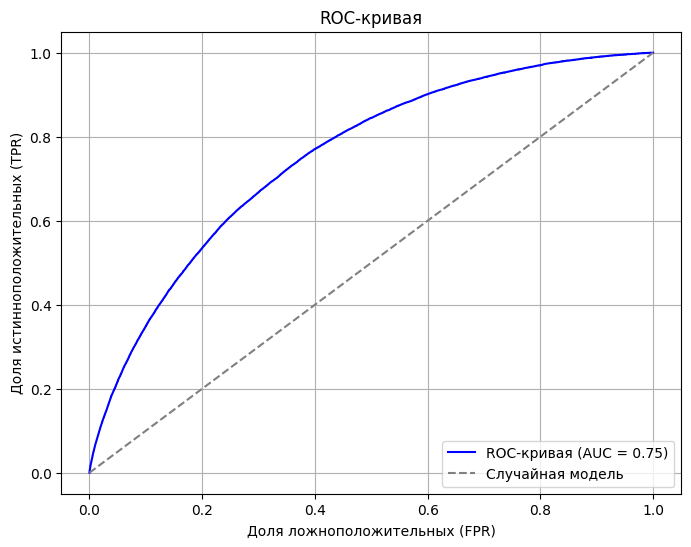

In [ ]:
plot_roc_curve(model, Xtest, ytest)

# **Lightgbm**

In [ ]:
lgbm=lgb.LGBMClassifier(objective='binary', is_unbalance=True, randoom_state=42)

In [ ]:
lgbm.fit(Xtrain, ytrain)

[LightGBM] [Info] Number of positive: 52156, number of negative: 1417844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.810449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15130
[LightGBM] [Info] Number of data points in the train set: 1470000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302653
[LightGBM] [Info] Start training from score -3.302653


LGBMClassifier(is_unbalance=True, objective='binary')

In [ ]:
# Оценка модели
evaluate_model(lgbm, Xval, yval)

AUC: 0.7448222520294333


0.7448222520294333

In [ ]:
importance = sorted(zip(map(lambda x: x, lgbm.feature_importances_), X.columns), reverse=True)

In [ ]:
importance

[(87, 'is_zero_loans530'),
 (82, 'is_zero_loans5'),
 (69, 'pre_pterm_14'),
 (66, 'pre_loans_outstanding_1'),
 (62, 'pre_since_opened_12'),
 (61, 'is_zero_loans3060'),
 (60, 'pre_loans_credit_cost_rate_11'),
 (60, 'mark_util'),
 (58, 'pre_loans_credit_limit_15'),
 (55, 'pre_loans_outstanding_5'),
 (55, 'enc_loans_credit_type_0'),
 (51, 'pre_loans_credit_cost_rate_9'),
 (49, 'pre_loans_credit_limit_0'),
 (47, 'pre_since_opened_7'),
 (47, 'pre_since_opened_19'),
 (46, 'pre_util_other'),
 (46, 'pre_loans_credit_cost_rate_7'),
 (45, 'pre_loans_credit_limit_2'),
 (43, 'pre_util_16'),
 (43, 'pre_since_opened_9'),
 (43, 'pre_loans_credit_cost_rate_4'),
 (42, 'is_zero_loans90'),
 (39, 'pre_loans_credit_limit_18'),
 (39, 'pre_loans_credit_cost_rate_13'),
 (39, 'mark_maxoverdue'),
 (38, 'pre_loans_credit_cost_rate_2'),
 (36, 'pre_loans_max_overdue_sum_2'),
 (36, 'enc_loans_credit_status_other'),
 (35, 'pre_since_opened_8'),
 (35, 'enc_loans_credit_type_3'),
 (34, 'enc_loans_credit_type_2'),
 (33,

**Подбор наиболее важных гиперпараметров**

In [ ]:
lgbm = lgb.LGBMClassifier(objective='binary', is_unbalance=True, random_state=42)
params = { 'n_estimators': [200, 300, 400],
                       'max_depth': [4,6,8],
                    'learning_rate': [0.1, 0.2, 0.3],
                    'num_leaves': [15, 31, 63, 127]
                  }

In [ ]:
scores=[]

clf = RandomizedSearchCV(lgbm, params, cv=4, n_iter=20, scoring='roc_auc', n_jobs=-1)
clf.fit(Xtrain, ytrain)
scores.append({
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })

[LightGBM] [Info] Number of positive: 52156, number of negative: 1417844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.781441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14980
[LightGBM] [Info] Number of data points in the train set: 1470000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302653
[LightGBM] [Info] Start training from score -3.302653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
clf.cv_results_

{'mean_fit_time': array([ 84.75312239,  74.98418629, 111.45809901, 179.06076014,
         58.23399186,  87.57803988, 100.40361995,  93.35451555,
         87.64429593, 106.6648562 ,  58.3405962 ,  72.93979967,
         63.34668565, 105.79259926, 102.57493317,  84.23220086,
        127.47050965,  89.06456369,  58.79443204,  75.09659785]),
 'std_fit_time': array([ 3.20794063,  3.73661354,  9.83667726, 10.3557844 ,  3.42196553,
        10.34104085,  6.34639146,  6.69316573,  7.65298116,  8.14841412,
         1.50093353,  4.60938477,  3.10844142,  3.14708763,  5.5274003 ,
         5.48749429,  1.48696982,  4.59673068,  0.5442375 ,  3.80184075]),
 'mean_score_time': array([ 4.29946703,  4.21723181,  7.6019603 , 13.66507077,  4.32760811,
         6.59705973,  6.47398072,  6.87378681,  6.55166656,  6.65825635,
         4.70630479,  6.13510114,  4.82825589,  6.79039139,  7.30811965,
         5.86829519,  8.7812385 ,  5.58660811,  4.62529784,  3.78320748]),
 'std_score_time': array([0.91383674, 

In [ ]:
clf.best_params_

{'num_leaves': 31, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1}

In [ ]:
clf.best_score_

0.7497637855404139

In [ ]:
lgbm=lgb.LGBMClassifier(objective='binary', is_unbalance=True, n_estimators= 450, max_depth=4, learning_rate=0.1)

In [ ]:
lgbm.fit(Xtrain, ytrain)

[LightGBM] [Info] Number of positive: 52156, number of negative: 1417844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.836197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15130
[LightGBM] [Info] Number of data points in the train set: 1470000, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035480 -> initscore=-3.302653
[LightGBM] [Info] Start training from score -3.302653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(is_unbalance=True, max_depth=4, n_estimators=450,
               objective='binary')

In [ ]:
# Оценка модели
evaluate_model(lgbm, Xval, yval)

AUC: 0.7509225772817055


0.7509225772817055

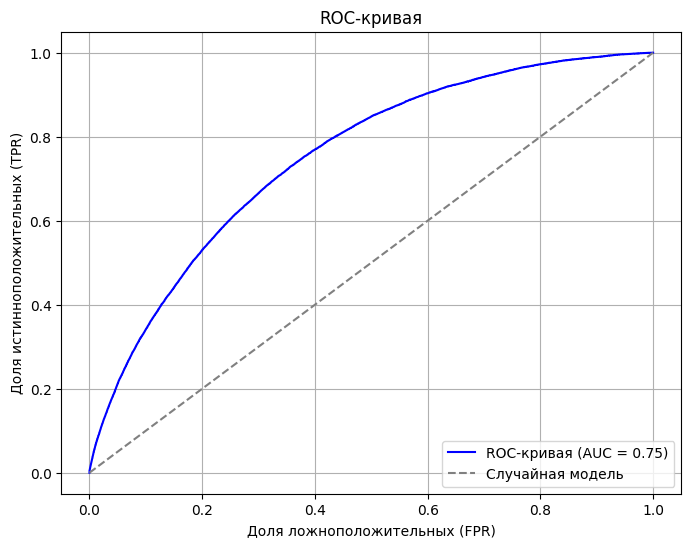

In [ ]:
plot_roc_curve(lgbm, Xval, yval)

In [ ]:
# Оценка модели на тестовых данных
evaluate_model(lgbm, Xtest, ytest)

AUC: 0.7493500176057879


0.7493500176057879

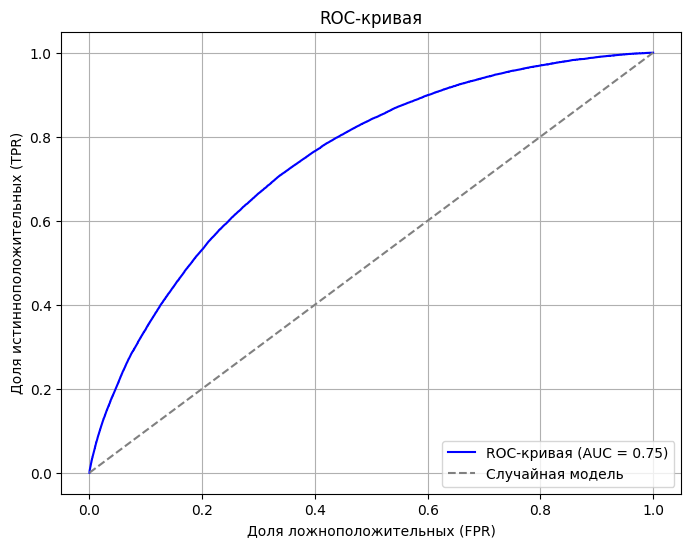

In [ ]:
plot_roc_curve(lgbm, Xtest, ytest)

# **Выбираем лучшую модель**

**Обе модели показывают практически одинаковое качество. Для дальнейшей работы выберем Catboost. Обучем модель на всех данных и сохраним в .pkl файл.**

In [ ]:
model = CatBoostClassifier(iterations=750, learning_rate=0.1, random_seed=42, depth=6, l2_leaf_reg=2.0, bagging_temperature=2.0, class_weights={0: 1, 1: 10})
model.fit(X, y, verbose=False)


In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']